# <center><b><font color='Green'>Identificação e classificação de doenças da folha do milho através do uso de Rede Neural Convolucional - Inteligência Artificial (EC37C)</font></b>

## **Autores**
Lucas Paschoalick

Luiz Felipe Alves Ferreira

Vítor Ângelo Misciato Teixeira

## **Apresentação**
Este notebook trata-se do estudo e implementação de um modelo baseado em CNN para classificar doenças presentes nas folhas do milho, desenvolvido como trabalho prático para a disciplina de Inteligência Artificial, ministrada na Universidade Tecnológica Federal do Paraná (UTFPR), *Campus* Cornélio Procópio. O conjunto de dados utilizado pode ser acessado a partir desse [link](https://www.kaggle.com/smaranjitghose/corn-or-maize-leaf-disease-dataset).

## **Importando pacotes e bibliotecas**

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.applications import EfficientNetB3, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

In [3]:
# Seed para reprodutibilidade
tf.random.set_seed(4)
tf.__version__

'2.6.2'

## **Importando dados de treino**

In [4]:
#Caminho dos dados
caminho_dados_treino = Path("dados/treino")

In [5]:
#Todos as imagens
imagens_treino = list(caminho_dados_treino.glob("*/*"))
imagens_treino[:5]               

[PosixPath('dados/treino/Blight/Corn_Blight (1).jpeg'),
 PosixPath('dados/treino/Blight/Corn_Blight (1).jpg'),
 PosixPath('dados/treino/Blight/Corn_Blight (10).jpg'),
 PosixPath('dados/treino/Blight/Corn_Blight (100).jpg'),
 PosixPath('dados/treino/Blight/Corn_Blight (101).jpg')]

In [6]:
#Retornando apenas a String do PosixPath
imagens_treino = list(map(lambda x: str(x), imagens_treino))
imagens_treino[:5]

['dados/treino/Blight/Corn_Blight (1).jpeg',
 'dados/treino/Blight/Corn_Blight (1).jpg',
 'dados/treino/Blight/Corn_Blight (10).jpg',
 'dados/treino/Blight/Corn_Blight (100).jpg',
 'dados/treino/Blight/Corn_Blight (101).jpg']

## **Manipulando os dados**

In [7]:
#Extraindo os labels de cada classe
imagens_treino_labels = [label.split("/")[-2] for label in imagens_treino]
imagens_treino_labels[:5]

['Blight', 'Blight', 'Blight', 'Blight', 'Blight']

In [8]:
#Aplicando label enconding (transformação de dados categóricos para numéricos)
encoder = LabelEncoder()
imagens_treino_labels = encoder.fit_transform(imagens_treino_labels)
imagens_treino_labels[1980:2000]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
#One-hot-encoding (converte os valores em um vetor binário para cada um)
imagens_treino_labels = tf.keras.utils.to_categorical(imagens_treino_labels)
imagens_treino_labels[1995:2000]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [10]:
#Dividindo o conjunto de dados em treino e validação (0.3 para teste)
x_train, x_validation, y_train, y_validation = train_test_split(imagens_treino, imagens_treino_labels, test_size = 0.3, random_state = 42)

In [11]:
print("Tamanho do conjunto de treino: ", len(x_train))
print("Tamanho do conjunto de validação: ", len(x_validation))

Tamanho do conjunto de treino:  2051
Tamanho do conjunto de validação:  880


In [12]:
x_train[20:30]

['dados/treino/Blight/Corn_Blight (663).JPG',
 'dados/treino/Common_Rust/Corn_Common_Rust (366).JPG',
 'dados/treino/Blight/Corn_Blight (349).JPG',
 'dados/treino/Common_Rust/Corn_Common_Rust (442).JPG',
 'dados/treino/Blight/Corn_Blight (372).JPG',
 'dados/treino/Common_Rust/Corn_Common_Rust (739).JPG',
 'dados/treino/Common_Rust/Corn_Common_Rust (906).JPG',
 'dados/treino/Common_Rust/Corn_Common_Rust (324).JPG',
 'dados/treino/Blight/Corn_Blight (48).jpg',
 'dados/treino/Blight/Corn_Blight (533).JPG']

In [13]:
y_train[20:30]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

## **Dataset Augmentation - Parâmetros**

In [15]:
# Redimensionamento de todas as imagens para 224 x 224
img_size = 224
resize = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(img_size, img_size)])

In [16]:
# Cria o objeto para dataset augmentation
data_augmentation = tf.keras.Sequential([RandomFlip("horizontal"),
                                         RandomRotation(0.2),
                                         RandomZoom(height_factor = (-0.3,-0.2)) ])

## **Preparando os dados para o modelo**

In [17]:
# Hiperparâmetros
batch_size = 16
autotune = tf.data.experimental.AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
# Função para carregar e transformar as imagens
def carrega_transforma(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    return image, label

In [19]:
# Função para preparar os dados noo formato do TensorFlow
def prepara_dataset(path, labels, train = True):

    # Prepara os dados
    image_paths = tf.convert_to_tensor(path)
    labels = tf.convert_to_tensor(labels)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    dataset = dataset.map(lambda image, label: carrega_transforma(image, label))
    dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls = autotune)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

    # Se train = True aplica dataset augmentation
    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls = autotune)
  
    # Se train = False repete sobre o dataset e retorna
    dataset = dataset.repeat()

    return dataset

In [20]:
# Cria o dataset de treino - Primeiro sem aplicar data augmentation
dataset_treino = prepara_dataset(x_train, y_train, train = True)

In [22]:
# Shape
imagem, label = next(iter(dataset_treino))
print(imagem.shape)
print(label.shape)

(16, 224, 224, 3)
(16, 4)


Common_Rust


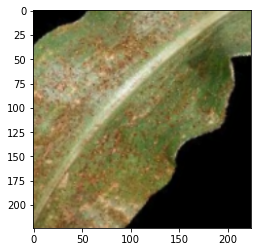

In [23]:
#Visualizando primeira imagem e label
print(encoder.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow(imagem[0].numpy().astype("uint8"))

In [24]:
# Cria o dataset de validação
dataset_validation = prepara_dataset(x_validation, y_validation, train = False)

## **Construção dos Modelos**

In [25]:
# Hiperparâmetros - Que por sinal os valores já são os default
lr = 0.001
beta1 = 0.9
beta2 = 0.999
ep = 1e-07

### **EfficientNetB3**

#### **Modelo 1**

In [133]:
# Carregando um modelo pré-treinado
modelo_pre_b3 = EfficientNetB3(input_shape = (224,224,3), include_top = False)
modelo_pre_b3.trainable = False
preprocess_input_b3 = tf.keras.applications.efficientnet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [86]:
#Modelo 1
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_b3(inputs)
x = modelo_pre_b3(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelo_b3_1 = tf.keras.Model(inputs, outputs)

In [69]:
modelo_b3_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 6148      
Total params: 10,789,683
Trainable params: 6,148
Non-trainable params: 10,783,535
_________________________________________________________________


In [70]:
# Compilação do modelo
modelo_b3_1.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [71]:
# Checkpoint
checkpoint_b3_1 = tf.keras.callbacks.ModelCheckpoint("modelo/modelob3_1.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

#### **Modelo 2**

In [26]:
# Carregando um modelo pré-treinado
modelo_pre_b3 = EfficientNetB3(input_shape = (224,224,3), include_top = False)
modelo_pre_b3.trainable = False
preprocess_input_b3 = tf.keras.applications.efficientnet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [122]:
#Modelo 2
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_b3(inputs)
x = modelo_pre_b3(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelo_b3_2 = tf.keras.Model(inputs, outputs)

In [123]:
modelo_b3_2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 6148      
Total params: 10,789,683
Trainable params: 6,148
Non-trainable params: 10,783,535
_________________________________________________________________


In [124]:
# Compilação do modelo
modelo_b3_2.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [125]:
# Checkpoint
checkpoint_b3_2 = tf.keras.callbacks.ModelCheckpoint("modelo/modelob3_2.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

#### **Modelo 3**

In [27]:
# Carregando um modelo pré-treinado
modelo_pre_b3 = EfficientNetB3(input_shape = (224,224,3), include_top = False)
modelo_pre_b3.trainable = False
preprocess_input_b3 = tf.keras.applications.efficientnet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [134]:
#Modelo 3
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_b3(inputs)
x = modelo_pre_b3(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.8)(x)
outputs = prediction_layer(x)
modelo_b3_3 = tf.keras.Model(inputs, outputs)

In [135]:
modelo_b3_3.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 6148      
Total params: 10,789,683
Trainable params: 6,148
Non-trainable params: 10,783,535
_________________________________________________________________


In [136]:
# Compilação do modelo
modelo_b3_3.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [137]:
# Checkpoint
checkpoint_b3_3 = tf.keras.callbacks.ModelCheckpoint("modelo/modelob3_3.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

### **ResNet50**

#### **Modelo 1**

In [177]:
# Carregando um modelo pré-treinado
modelo_pre_res = ResNet50(input_shape = (224,224,3), include_top = False)
modelo_pre_res.trainable = False
preprocess_input_res = tf.keras.applications.resnet50.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [93]:
#Modelo 1
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_res(inputs)
x = modelo_pre_res(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelo_res_1 = tf.keras.Model(inputs, outputs)

In [94]:
modelo_res_1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
___________________________________________

In [95]:
# Compilação do modelo
modelo_res_1.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [96]:
# Checkpoint
checkpoint_res_1 = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_res_1.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

#### **Modelo 2**

In [31]:
# Carregando um modelo pré-treinado
modelo_pre_res = ResNet50(input_shape = (224,224,3), include_top = False)
modelo_pre_res.trainable = False
preprocess_input_res = tf.keras.applications.resnet50.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [144]:
#Modelo 2
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_res(inputs)
x = modelo_pre_res(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelo_res_2 = tf.keras.Model(inputs, outputs)

In [145]:
modelo_res_2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 8196

In [146]:
# Compilação do modelo
modelo_res_2.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [147]:
# Checkpoint
checkpoint_res_2 = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_res_2.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

#### **Modelo 3**

In [32]:
# Carregando um modelo pré-treinado
modelo_pre_res = ResNet50(input_shape = (224,224,3), include_top = False)
modelo_pre_res.trainable = False
preprocess_input_res = tf.keras.applications.resnet50.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [178]:
#Modelo 3
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_res(inputs)
x = modelo_pre_res(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.8)(x)
outputs = prediction_layer(x)
modelo_res_3 = tf.keras.Model(inputs, outputs)

In [179]:
modelo_res_3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_14  (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 819

In [180]:
# Compilação do modelo
modelo_res_3.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [181]:
# Checkpoint
checkpoint_res_3 = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_res_3.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

### **MobileNetV2**

#### **Modelo 1**

In [164]:
# Carregando um modelo pré-treinado
modelo_pre_mob = MobileNetV2(input_shape = (224,224,3), include_top = False)
modelo_pre_mob.trainable = False
preprocess_input_mob = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [110]:
#Modelo 1
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_mob(inputs)
x = modelo_pre_mob(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelo_mob_1 = tf.keras.Model(inputs, outputs)

In [112]:
modelo_mob_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_____________________________________________

In [113]:
# Compilação do modelo
modelo_mob_1.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [114]:
# Checkpoint
checkpoint_mob_1 = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_mob_1.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

#### **Modelo 2**

In [33]:
# Carregando um modelo pré-treinado
modelo_pre_mob = MobileNetV2(input_shape = (224,224,3), include_top = False)
modelo_pre_mob.trainable = False
preprocess_input_mob = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [154]:
#Modelo 2
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_mob(inputs)
x = modelo_pre_mob(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelo_mob_2 = tf.keras.Model(inputs, outputs)

In [155]:
modelo_mob_2.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 5124

In [156]:
# Compilação do modelo
modelo_mob_2.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [157]:
# Checkpoint
checkpoint_mob_2 = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_mob_2.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

#### **Modelo 3**

In [34]:
# Carregando um modelo pré-treinado
modelo_pre_mob = MobileNetV2(input_shape = (224,224,3), include_top = False)
modelo_pre_mob.trainable = False
preprocess_input_mob = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')

In [165]:
#Modelo 3
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input_mob(inputs)
x = modelo_pre_mob(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.8)(x)
outputs = prediction_layer(x)
modelo_mob_3 = tf.keras.Model(inputs, outputs)

In [166]:
modelo_mob_3.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 512

In [167]:
# Compilação do modelo
modelo_mob_3.compile(optimizer = Adam(learning_rate = lr, 
                                beta_1 = beta1, 
                                beta_2 = beta2, 
                                epsilon = ep),
                                loss = 'categorical_crossentropy',
                                metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [168]:
# Checkpoint
checkpoint_mob_3 = tf.keras.callbacks.ModelCheckpoint("modelo/modelo_mob_3.h5", 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

## **Treinando os modelos**

### **EfficientNetB3**

#### **Modelo 1**

In [72]:
%%time
history_b3_1 = modelo_b3_1.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_b3_1])

Epoch 1/10
128/128 [==============================] - 250s 2s/step - loss: 0.1530 - accuracy: 0.9445 - precision: 0.9533 - recall: 0.9337 - val_loss: 0.2119 - val_accuracy: 0.9189 - val_precision: 0.9259 - val_recall: 0.9087

Epoch 00001: saving model to modelo/modelob3_1.h5
Epoch 2/10
128/128 [==============================] - 243s 2s/step - loss: 0.1514 - accuracy: 0.9445 - precision: 0.9510 - recall: 0.9346 - val_loss: 0.2228 - val_accuracy: 0.9155 - val_precision: 0.9223 - val_recall: 0.9102

Epoch 00002: saving model to modelo/modelob3_1.h5
Epoch 3/10
128/128 [==============================] - 242s 2s/step - loss: 0.1481 - accuracy: 0.9415 - precision: 0.9472 - recall: 0.9342 - val_loss: 0.2251 - val_accuracy: 0.9160 - val_precision: 0.9193 - val_recall: 0.9116

Epoch 00003: saving model to modelo/modelob3_1.h5
Epoch 4/10
128/128 [==============================] - 236s 2s/step - loss: 0.1414 - accuracy: 0.9473 - precision: 0.9543 - recall: 0.9380 - val_loss: 0.2130 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

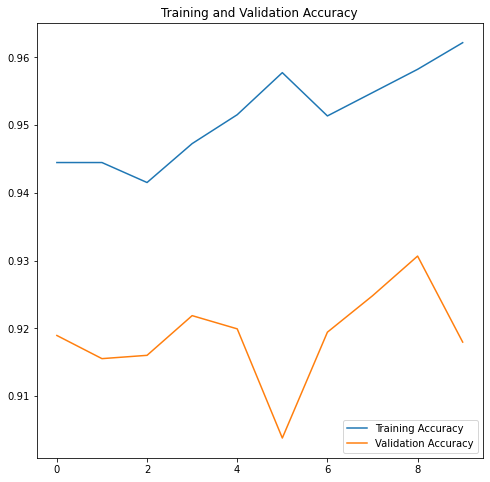

In [74]:
acc = history_b3_1.history['accuracy']
val_acc = history_b3_1.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### **Modelo 2**

In [126]:
%%time
history_b3_2 = modelo_b3_2.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_b3_2])

Epoch 1/10
128/128 [==============================] - 293s 2s/step - loss: 0.5620 - accuracy: 0.8000 - precision: 0.9030 - recall: 0.6865 - val_loss: 0.3524 - val_accuracy: 0.8853 - val_precision: 0.9199 - val_recall: 0.8462

Epoch 00001: saving model to modelo/modelob3_2.h5
Epoch 2/10
128/128 [==============================] - 288s 2s/step - loss: 0.3313 - accuracy: 0.8757 - precision: 0.9078 - recall: 0.8467 - val_loss: 0.2924 - val_accuracy: 0.9102 - val_precision: 0.9354 - val_recall: 0.8838

Epoch 00002: saving model to modelo/modelob3_2.h5
Epoch 3/10
128/128 [==============================] - 265s 2s/step - loss: 0.2711 - accuracy: 0.8983 - precision: 0.9226 - recall: 0.8732 - val_loss: 0.2534 - val_accuracy: 0.9146 - val_precision: 0.9315 - val_recall: 0.8965

Epoch 00003: saving model to modelo/modelob3_2.h5
Epoch 4/10
128/128 [==============================] - 293s 2s/step - loss: 0.2388 - accuracy: 0.9125 - precision: 0.9314 - recall: 0.8934 - val_loss: 0.2587 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

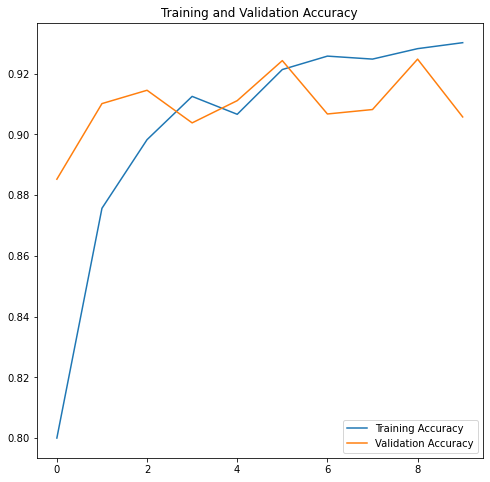

In [127]:
acc = history_b3_2.history['accuracy']
val_acc = history_b3_2.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### **Modelo 3**

In [138]:
%%time
history_b3_3 = modelo_b3_3.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_b3_3])

Epoch 1/10
128/128 [==============================] - 335s 3s/step - loss: 0.8558 - accuracy: 0.6555 - precision: 0.7390 - recall: 0.5607 - val_loss: 0.4571 - val_accuracy: 0.8184 - val_precision: 0.8564 - val_recall: 0.7803

Epoch 00001: saving model to modelo/modelob3_3.h5
Epoch 2/10
128/128 [==============================] - 293s 2s/step - loss: 0.5084 - accuracy: 0.8010 - precision: 0.8457 - recall: 0.7622 - val_loss: 0.3836 - val_accuracy: 0.8418 - val_precision: 0.8626 - val_recall: 0.8154

Epoch 00002: saving model to modelo/modelob3_3.h5
Epoch 3/10
128/128 [==============================] - 333s 3s/step - loss: 0.4550 - accuracy: 0.8172 - precision: 0.8506 - recall: 0.7887 - val_loss: 0.3296 - val_accuracy: 0.8682 - val_precision: 0.8836 - val_recall: 0.8374

Epoch 00003: saving model to modelo/modelob3_3.h5
Epoch 4/10
128/128 [==============================] - 295s 2s/step - loss: 0.3857 - accuracy: 0.8496 - precision: 0.8743 - recall: 0.8201 - val_loss: 0.3127 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

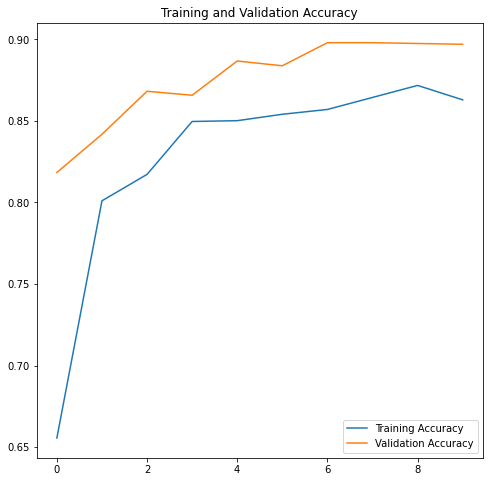

In [195]:
acc = history_b3_3.history['accuracy']
val_acc = history_b3_3.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

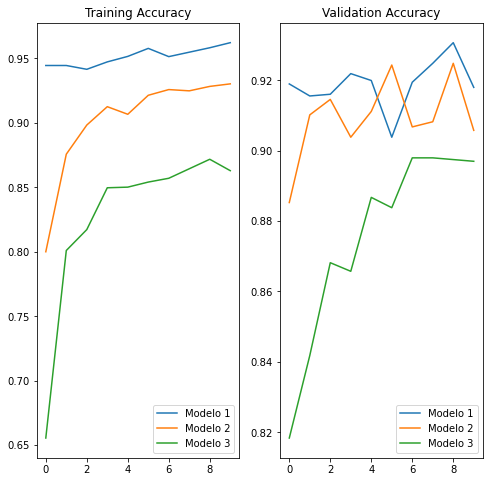

In [194]:
#Gráfico das acurácias dos 3 modelos
acc1 = history_b3_1.history['accuracy']
acc2 = history_b3_2.history['accuracy']
acc3 = history_b3_3.history['accuracy']
val_acc1 = history_b3_1.history['val_accuracy']
val_acc2 = history_b3_2.history['val_accuracy']
val_acc3 = history_b3_3.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Modelo 1')
plt.plot(epochs_range, acc2, label='Modelo 2')
plt.plot(epochs_range, acc3, label='Modelo 3')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc1, label='Modelo 1')
plt.plot(epochs_range, val_acc2, label='Modelo 2')
plt.plot(epochs_range, val_acc3, label='Modelo 3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

### **ResNet50**

#### **Modelo 1**

In [97]:
%%time
history_res_1 = modelo_res_1.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_res_1])

Epoch 1/10
128/128 [==============================] - 419s 3s/step - loss: 0.3943 - accuracy: 0.8477 - precision: 0.8872 - recall: 0.8157 - val_loss: 0.2790 - val_accuracy: 0.8950 - val_precision: 0.9001 - val_recall: 0.8936

Epoch 00001: saving model to modelo/modelo_res_1.h5
Epoch 2/10
128/128 [==============================] - 347s 3s/step - loss: 0.2197 - accuracy: 0.9179 - precision: 0.9270 - recall: 0.9052 - val_loss: 0.2604 - val_accuracy: 0.9048 - val_precision: 0.9057 - val_recall: 0.9009

Epoch 00002: saving model to modelo/modelo_res_1.h5
Epoch 3/10
128/128 [==============================] - 379s 3s/step - loss: 0.1816 - accuracy: 0.9263 - precision: 0.9356 - recall: 0.9204 - val_loss: 0.1988 - val_accuracy: 0.9321 - val_precision: 0.9374 - val_recall: 0.9214

Epoch 00003: saving model to modelo/modelo_res_1.h5
Epoch 4/10
128/128 [==============================] - 388s 3s/step - loss: 0.1624 - accuracy: 0.9361 - precision: 0.9446 - recall: 0.9297 - val_loss: 0.2372 - val_acc

Text(0.5, 1.0, 'Training and Validation Accuracy')

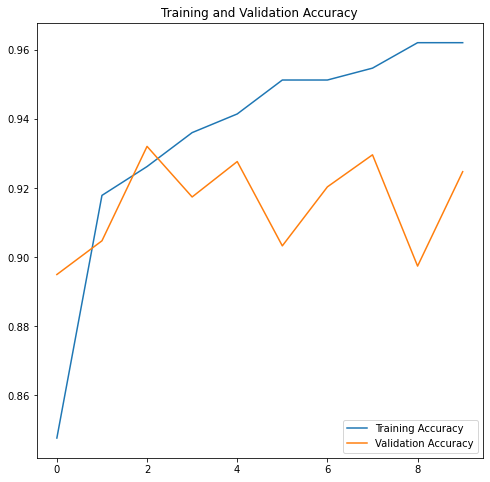

In [98]:
acc = history_res_1.history['accuracy']
val_acc = history_res_1.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### **Modelo 2**

In [148]:
%%time
history_res_2 = modelo_res_2.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_res_2])

Epoch 1/10
128/128 [==============================] - 374s 3s/step - loss: 0.4203 - accuracy: 0.8354 - precision: 0.8644 - recall: 0.8084 - val_loss: 0.3517 - val_accuracy: 0.8750 - val_precision: 0.8780 - val_recall: 0.8716

Epoch 00001: saving model to modelo/modelo_res_2.h5
Epoch 2/10
128/128 [==============================] - 366s 3s/step - loss: 0.2363 - accuracy: 0.9091 - precision: 0.9164 - recall: 0.8993 - val_loss: 0.2139 - val_accuracy: 0.9253 - val_precision: 0.9289 - val_recall: 0.9185

Epoch 00002: saving model to modelo/modelo_res_2.h5
Epoch 3/10
128/128 [==============================] - 363s 3s/step - loss: 0.2132 - accuracy: 0.9179 - precision: 0.9237 - recall: 0.9106 - val_loss: 0.2201 - val_accuracy: 0.9307 - val_precision: 0.9325 - val_recall: 0.9307

Epoch 00003: saving model to modelo/modelo_res_2.h5
Epoch 4/10
128/128 [==============================] - 389s 3s/step - loss: 0.1821 - accuracy: 0.9243 - precision: 0.9289 - recall: 0.9174 - val_loss: 0.3057 - val_acc

Text(0.5, 1.0, 'Training and Validation Accuracy')

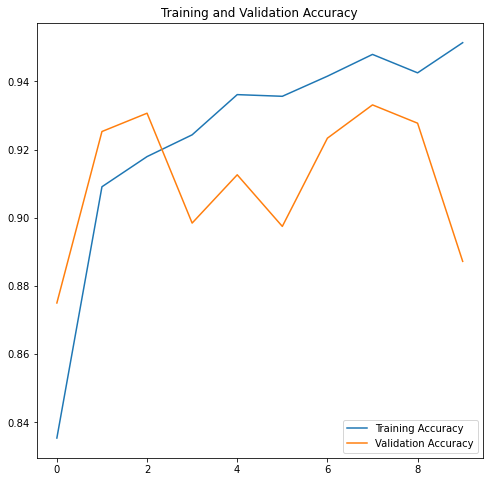

In [169]:
acc = history_res_2.history['accuracy']
val_acc = history_res_2.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### **Modelo 3**

In [183]:
%%time
history_res_3 = modelo_res_3.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_res_3])

Epoch 1/10
128/128 [==============================] - 361s 3s/step - loss: 1.0873 - accuracy: 0.6796 - precision: 0.6990 - recall: 0.6550 - val_loss: 0.3138 - val_accuracy: 0.8755 - val_precision: 0.8816 - val_recall: 0.8687

Epoch 00001: saving model to modelo/modelo_res_3.h5
Epoch 2/10
128/128 [==============================] - 325s 3s/step - loss: 0.5723 - accuracy: 0.8054 - precision: 0.8208 - recall: 0.7946 - val_loss: 0.3304 - val_accuracy: 0.8784 - val_precision: 0.8804 - val_recall: 0.8730

Epoch 00002: saving model to modelo/modelo_res_3.h5
Epoch 3/10
128/128 [==============================] - 314s 2s/step - loss: 0.4178 - accuracy: 0.8541 - precision: 0.8626 - recall: 0.8388 - val_loss: 0.3988 - val_accuracy: 0.8745 - val_precision: 0.8774 - val_recall: 0.8735

Epoch 00003: saving model to modelo/modelo_res_3.h5
Epoch 4/10
128/128 [==============================] - 312s 2s/step - loss: 0.4069 - accuracy: 0.8693 - precision: 0.8791 - recall: 0.8609 - val_loss: 0.2363 - val_acc

Text(0.5, 1.0, 'Training and Validation Accuracy')

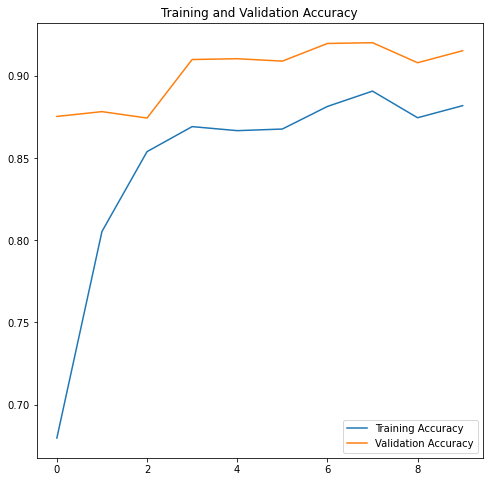

In [184]:
acc = history_res_3.history['accuracy']
val_acc = history_res_3.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

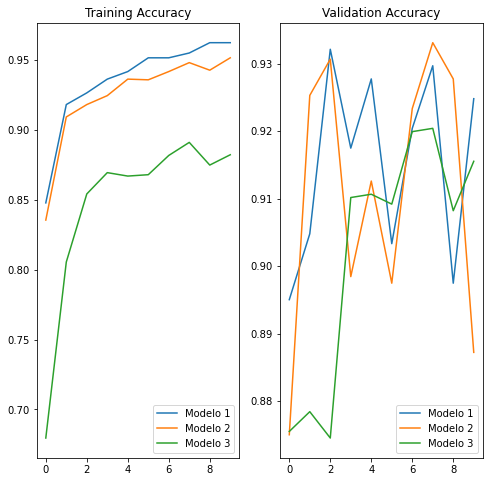

In [193]:
#Gráfico das acurácias dos 3 modelos
acc1 = history_res_1.history['accuracy']
acc2 = history_res_2.history['accuracy']
acc3 = history_res_3.history['accuracy']
val_acc1 = history_res_1.history['val_accuracy']
val_acc2 = history_res_2.history['val_accuracy']
val_acc3 = history_res_3.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Modelo 1')
plt.plot(epochs_range, acc2, label='Modelo 2')
plt.plot(epochs_range, acc3, label='Modelo 3')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc1, label='Modelo 1')
plt.plot(epochs_range, val_acc2, label='Modelo 2')
plt.plot(epochs_range, val_acc3, label='Modelo 3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

### **MobileNetV2**

#### **Modelo 1**

In [115]:
%%time
history_mob_1 = modelo_mob_1.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_mob_1])

Epoch 1/10
128/128 [==============================] - 70s 530ms/step - loss: 0.4987 - accuracy: 0.8231 - precision: 0.8672 - recall: 0.7671 - val_loss: 0.2917 - val_accuracy: 0.8872 - val_precision: 0.9021 - val_recall: 0.8594

Epoch 00001: saving model to modelo/modelo_mob_1.h5
Epoch 2/10
128/128 [==============================] - 70s 548ms/step - loss: 0.2837 - accuracy: 0.8892 - precision: 0.9089 - recall: 0.8716 - val_loss: 0.2599 - val_accuracy: 0.8916 - val_precision: 0.9017 - val_recall: 0.8779

Epoch 00002: saving model to modelo/modelo_mob_1.h5
Epoch 3/10
128/128 [==============================] - 68s 536ms/step - loss: 0.2343 - accuracy: 0.9065 - precision: 0.9217 - recall: 0.8966 - val_loss: 0.2343 - val_accuracy: 0.9077 - val_precision: 0.9148 - val_recall: 0.8911

Epoch 00003: saving model to modelo/modelo_mob_1.h5
Epoch 4/10
128/128 [==============================] - 69s 542ms/step - loss: 0.2166 - accuracy: 0.9243 - precision: 0.9320 - recall: 0.9155 - val_loss: 0.2279 -

Text(0.5, 1.0, 'Training and Validation Accuracy')

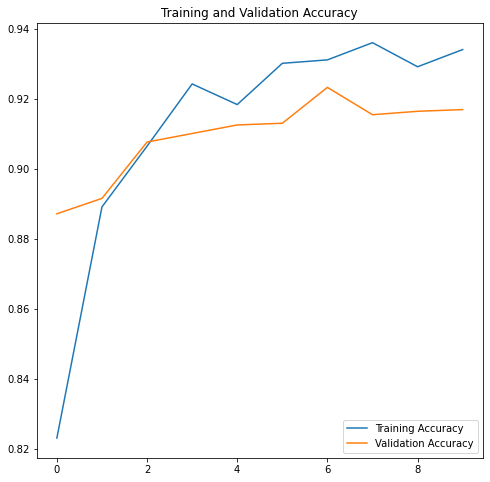

In [116]:
acc = history_mob_1.history['accuracy']
val_acc = history_mob_1.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### **Modelo 2**

In [158]:
%%time
history_mob_2 = modelo_mob_2.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_mob_2])

Epoch 1/10
128/128 [==============================] - 69s 524ms/step - loss: 0.5978 - accuracy: 0.7759 - precision: 0.8276 - recall: 0.7312 - val_loss: 0.3089 - val_accuracy: 0.8760 - val_precision: 0.9035 - val_recall: 0.8501

Epoch 00001: saving model to modelo/modelo_mob_2.h5
Epoch 2/10
128/128 [==============================] - 68s 536ms/step - loss: 0.3182 - accuracy: 0.8747 - precision: 0.8959 - recall: 0.8585 - val_loss: 0.2824 - val_accuracy: 0.9009 - val_precision: 0.9107 - val_recall: 0.8760

Epoch 00002: saving model to modelo/modelo_mob_2.h5
Epoch 3/10
128/128 [==============================] - 69s 539ms/step - loss: 0.2750 - accuracy: 0.9047 - precision: 0.9167 - recall: 0.8865 - val_loss: 0.2704 - val_accuracy: 0.8955 - val_precision: 0.9077 - val_recall: 0.8833

Epoch 00003: saving model to modelo/modelo_mob_2.h5
Epoch 4/10
128/128 [==============================] - 69s 542ms/step - loss: 0.2464 - accuracy: 0.8939 - precision: 0.9059 - recall: 0.8850 - val_loss: 0.2216 -

Text(0.5, 1.0, 'Training and Validation Accuracy')

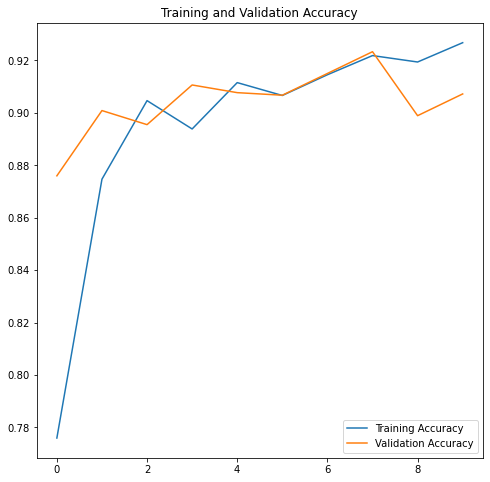

In [170]:
acc = history_mob_2.history['accuracy']
val_acc = history_mob_2.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### **Modelo 3**

In [171]:
%%time
history_mob_3 = modelo_mob_3.fit(dataset_treino,
                     steps_per_epoch = len(x_train)//batch_size,
                     epochs = 10,
                     validation_data = dataset_validation,
                     validation_steps = len(y_train)//batch_size,
                     callbacks = [checkpoint_mob_3])

Epoch 1/10
128/128 [==============================] - 69s 526ms/step - loss: 1.4368 - accuracy: 0.5553 - precision: 0.5754 - recall: 0.5287 - val_loss: 0.4220 - val_accuracy: 0.8276 - val_precision: 0.8564 - val_recall: 0.7949

Epoch 00001: saving model to modelo/modelo_mob_3.h5
Epoch 2/10
128/128 [==============================] - 68s 534ms/step - loss: 0.7444 - accuracy: 0.7528 - precision: 0.7691 - recall: 0.7332 - val_loss: 0.3056 - val_accuracy: 0.8687 - val_precision: 0.8868 - val_recall: 0.8530

Epoch 00002: saving model to modelo/modelo_mob_3.h5
Epoch 3/10
128/128 [==============================] - 69s 543ms/step - loss: 0.6008 - accuracy: 0.7862 - precision: 0.8026 - recall: 0.7690 - val_loss: 0.2751 - val_accuracy: 0.8843 - val_precision: 0.8997 - val_recall: 0.8721

Epoch 00003: saving model to modelo/modelo_mob_3.h5
Epoch 4/10
128/128 [==============================] - 69s 544ms/step - loss: 0.5275 - accuracy: 0.8113 - precision: 0.8281 - recall: 0.7956 - val_loss: 0.2591 -

Text(0.5, 1.0, 'Training and Validation Accuracy')

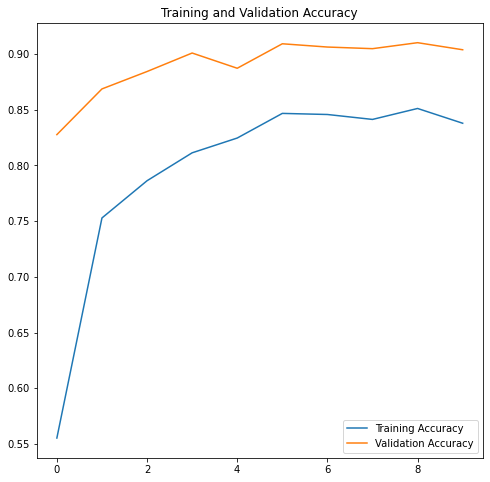

In [182]:
acc = history_mob_3.history['accuracy']
val_acc = history_mob_3.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

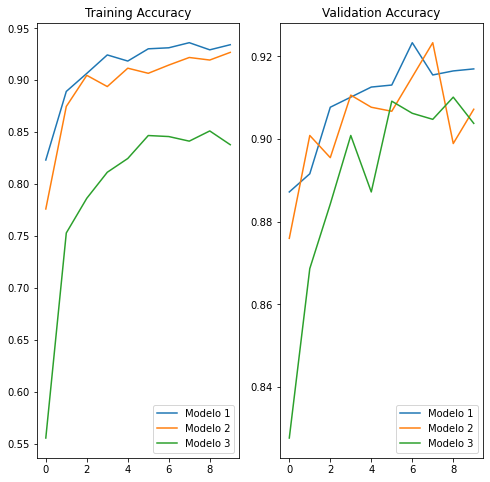

In [192]:
#Gráfico das acurácias dos 3 modelos
acc1 = history_mob_1.history['accuracy']
acc2 = history_mob_2.history['accuracy']
acc3 = history_mob_3.history['accuracy']
val_acc1 = history_mob_1.history['val_accuracy']
val_acc2 = history_mob_2.history['val_accuracy']
val_acc3 = history_mob_3.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Modelo 1')
plt.plot(epochs_range, acc2, label='Modelo 2')
plt.plot(epochs_range, acc3, label='Modelo 3')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc1, label='Modelo 1')
plt.plot(epochs_range, val_acc2, label='Modelo 2')
plt.plot(epochs_range, val_acc3, label='Modelo 3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.show()

## **Carregando conjunto de testes**

In [47]:
#Caminho dos dados
caminho_dados_teste = Path("dados/teste")

In [51]:
#Todos as imagens
imagens_teste = list(caminho_dados_teste.glob("*/*"))
imagens_teste[:5]               

[PosixPath('dados/teste/Blight/Corn_Blight (1000).JPG'),
 PosixPath('dados/teste/Blight/Corn_Blight (1001).JPG'),
 PosixPath('dados/teste/Blight/Corn_Blight (1002).JPG'),
 PosixPath('dados/teste/Blight/Corn_Blight (1003).JPG'),
 PosixPath('dados/teste/Blight/Corn_Blight (1004).JPG')]

In [52]:
#Retornando apenas a String do PosixPath
imagens_teste = list(map(lambda x: str(x), imagens_teste))
imagens_teste[:5]

['dados/teste/Blight/Corn_Blight (1000).JPG',
 'dados/teste/Blight/Corn_Blight (1001).JPG',
 'dados/teste/Blight/Corn_Blight (1002).JPG',
 'dados/teste/Blight/Corn_Blight (1003).JPG',
 'dados/teste/Blight/Corn_Blight (1004).JPG']

In [53]:
#Extraindo os labels de cada classe
imagens_teste_labels = [label.split("/")[-2] for label in imagens_teste]
imagens_teste_labels[:5]

['Blight', 'Blight', 'Blight', 'Blight', 'Blight']

In [55]:
#Aplicando label enconding (transformação de dados categóricos para numéricos)
imagens_teste_labels = encoder.fit_transform(imagens_teste_labels)
imagens_teste_labels[25:30]

array([0, 0, 0, 0, 0])

## **Avaliando os modelos**

In [ ]:
#importando as funções estatísticas
from sklearn.metrics import classification_report,accuracy_score, precision_recall_fscore_support

In [57]:
# Função para carregar uma nova imagem
def carrega_nova_imagem(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224,224], method = "bilinear")
    image = tf.expand_dims(image, 0) 
    return image

In [61]:
# Função para fazer previsões
def faz_previsao(image_path, model):
    image = carrega_nova_imagem(image_path)
    prediction = model.predict(image)
    pred = np.argmax(prediction, axis = 1) 
    return pred[0] 

### **EfficientNetB3**

#### **Modelo 1**

In [99]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_b3_1.layers[0].trainable = True
modelo_salvo_b3_1 = modelo_b3_1
modelo_salvo_b3_1.load_weights("modelo/modelob3_1.h5")

In [128]:
# Previsão - Modelo 1
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_b3_1))

In [101]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.9021479713603818
(array([0.7704918 , 0.97112861, 0.88333333, 1.        ]), array([0.95639535, 0.94387755, 0.61627907, 0.94269341]), array([0.85343709, 0.95730918, 0.7260274 , 0.97050147]), array([344, 392, 172, 349]))


In [102]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       344
           1       0.97      0.94      0.96       392
           2       0.88      0.62      0.73       172
           3       1.00      0.94      0.97       349

    accuracy                           0.90      1257
   macro avg       0.91      0.86      0.88      1257
weighted avg       0.91      0.90      0.90      1257



#### **Modelo 2**

In [129]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_b3_2.layers[0].trainable = True
modelo_salvo_b3_2 = modelo_b3_2
modelo_salvo_b3_2.load_weights("modelo/modelob3_2.h5")

In [130]:
# Previsão - Modelo 2
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_b3_2))

In [131]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.8814638027048528
(array([0.71888412, 0.96596859, 0.94594595, 0.99701493]), array([0.97383721, 0.94132653, 0.40697674, 0.95702006]), array([0.82716049, 0.95348837, 0.56910569, 0.97660819]), array([344, 392, 172, 349]))


In [132]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       344
           1       0.97      0.94      0.95       392
           2       0.95      0.41      0.57       172
           3       1.00      0.96      0.98       349

    accuracy                           0.88      1257
   macro avg       0.91      0.82      0.83      1257
weighted avg       0.90      0.88      0.87      1257



#### **Modelo 3**

In [139]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_b3_3.layers[0].trainable = True
modelo_salvo_b3_3 = modelo_b3_3
modelo_salvo_b3_3.load_weights("modelo/modelob3_3.h5")

In [140]:
# Previsão - Modelo 2
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_b3_3))

In [141]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.8695306284805091
(array([0.70299145, 0.97311828, 0.84946237, 0.99691358]), array([0.95639535, 0.92346939, 0.45930233, 0.92550143]), array([0.81034483, 0.94764398, 0.59622642, 0.95988113]), array([344, 392, 172, 349]))


In [142]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       344
           1       0.97      0.92      0.95       392
           2       0.85      0.46      0.60       172
           3       1.00      0.93      0.96       349

    accuracy                           0.87      1257
   macro avg       0.88      0.82      0.83      1257
weighted avg       0.89      0.87      0.87      1257



### **ResNet50**

#### **Modelo 1**

In [103]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_res_1.layers[0].trainable = True
modelo_salvo_res_1 = modelo_res_1
modelo_salvo_res_1.load_weights("modelo/modelo_res_1.h5")

In [104]:
# Previsão
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_res_1))

In [105]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.9180588703261734
(array([0.79107981, 0.97692308, 0.95744681, 0.99711816]), array([0.97965116, 0.97193878, 0.52325581, 0.99140401]), array([0.87532468, 0.97442455, 0.67669173, 0.99425287]), array([344, 392, 172, 349]))


In [106]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88       344
           1       0.98      0.97      0.97       392
           2       0.96      0.52      0.68       172
           3       1.00      0.99      0.99       349

    accuracy                           0.92      1257
   macro avg       0.93      0.87      0.88      1257
weighted avg       0.93      0.92      0.91      1257



#### **Modelo 2**

In [149]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_res_2.layers[0].trainable = True
modelo_salvo_res_2 = modelo_res_2
modelo_salvo_res_2.load_weights("modelo/modelo_res_2.h5")

In [150]:
# Previsão - Modelo 2
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_res_2))

In [151]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.8727128082736675
(array([0.68888889, 0.99186992, 0.95652174, 0.99711816]), array([0.99127907, 0.93367347, 0.25581395, 0.99140401]), array([0.81287247, 0.96189225, 0.40366972, 0.99425287]), array([344, 392, 172, 349]))


In [152]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81       344
           1       0.99      0.93      0.96       392
           2       0.96      0.26      0.40       172
           3       1.00      0.99      0.99       349

    accuracy                           0.87      1257
   macro avg       0.91      0.79      0.79      1257
weighted avg       0.91      0.87      0.85      1257



#### **Modelo 3**

In [185]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_res_3.layers[0].trainable = True
modelo_salvo_res_3 = modelo_res_3
modelo_salvo_res_3.load_weights("modelo/modelo_res_3.h5")

In [186]:
# Previsão - Modelo 3
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_res_3))

In [187]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.9196499602227526
(array([0.80434783, 0.96923077, 0.93457944, 0.99710983]), array([0.96802326, 0.96428571, 0.58139535, 0.98853868]), array([0.87862797, 0.96675192, 0.71684588, 0.99280576]), array([344, 392, 172, 349]))


In [188]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       344
           1       0.97      0.96      0.97       392
           2       0.93      0.58      0.72       172
           3       1.00      0.99      0.99       349

    accuracy                           0.92      1257
   macro avg       0.93      0.88      0.89      1257
weighted avg       0.93      0.92      0.92      1257



### **MobileNetV2**

#### **Modelo 1**

In [117]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_mob_1.layers[0].trainable = True
modelo_salvo_mob_1 = modelo_mob_1
modelo_salvo_mob_1.load_weights("modelo/modelo_mob_1.h5")

In [118]:
# Previsão
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_mob_1))

In [119]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.8973747016706444
(array([0.75      , 0.97402597, 0.91666667, 0.99425287]), array([0.95930233, 0.95663265, 0.44767442, 0.99140401]), array([0.84183673, 0.96525097, 0.6015625 , 0.9928264 ]), array([344, 392, 172, 349]))


In [120]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       344
           1       0.97      0.96      0.97       392
           2       0.92      0.45      0.60       172
           3       0.99      0.99      0.99       349

    accuracy                           0.90      1257
   macro avg       0.91      0.84      0.85      1257
weighted avg       0.91      0.90      0.89      1257



#### **Modelo 2**

In [159]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_mob_2.layers[0].trainable = True
modelo_salvo_mob_2 = modelo_mob_2
modelo_salvo_mob_2.load_weights("modelo/modelo_mob_2.h5")

In [160]:
# Previsão - Modelo 2
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_mob_2))

In [161]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.8933969769291965
(array([0.7454955 , 0.96899225, 0.91566265, 0.9941691 ]), array([0.9622093 , 0.95663265, 0.44186047, 0.97707736]), array([0.84010152, 0.96277279, 0.59607843, 0.98554913]), array([344, 392, 172, 349]))


In [162]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       344
           1       0.97      0.96      0.96       392
           2       0.92      0.44      0.60       172
           3       0.99      0.98      0.99       349

    accuracy                           0.89      1257
   macro avg       0.91      0.83      0.85      1257
weighted avg       0.91      0.89      0.89      1257



#### **Modelo 3**

In [173]:
# Carrega os pesos do ponto de verificação e reavalie
modelo_mob_3.layers[0].trainable = True
modelo_salvo_mob_3 = modelo_mob_3
modelo_salvo_mob_3.load_weights("modelo/modelo_mob_3.h5")

In [174]:
# Previsão - Modelo 3
previsoes = []
for img in imagens_teste:
    previsoes.append(faz_previsao(img, modelo_salvo_mob_3))

In [175]:
print(accuracy_score(imagens_teste_labels, previsoes))
print(precision_recall_fscore_support(imagens_teste_labels, previsoes))

0.8926014319809069
(array([0.74886878, 0.96569921, 0.89772727, 0.99425287]), array([0.9622093 , 0.93367347, 0.45930233, 0.99140401]), array([0.84223919, 0.94941634, 0.60769231, 0.9928264 ]), array([344, 392, 172, 349]))


In [176]:
print(classification_report(imagens_teste_labels, previsoes))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       344
           1       0.97      0.93      0.95       392
           2       0.90      0.46      0.61       172
           3       0.99      0.99      0.99       349

    accuracy                           0.89      1257
   macro avg       0.90      0.84      0.85      1257
weighted avg       0.90      0.89      0.89      1257

